## Reinforcement learning example with stable-baselines3

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/neurogym/blob/master/examples/example_neurogym_rl.ipynb)

NeuroGym is a toolkit that allows training any network model on many established neuroscience tasks techniques such as standard Supervised  Learning or Reinforcement Learning (RL). In this notebook we will use RL to train an LSTM network on the classical Random Dots Motion (RDM) task (Britten et al. 1992).

We first show how to install the relevant toolboxes. We then show how build the task of interest (in the example the RDM task), wrapp it with the pass-reward wrapper in one line and visualize the structure of the final task. Finally we train an LSTM network on the task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) toolbox, and plot the results.

It is straightforward to change the code to train a network on any other available task or using a different RL algorithm (e.g. ACER, PPO2).


### Task

here we build the Random Dots Motion task, specifying the duration of each trial period (fixation, stimulus, decision) and wrapp it with the pass-reward wrapper which appends the previous reward to the observation. We then plot the structure of the task in a figure that shows: 
1. The observations received by the agent (top panel). 
2. The actions taken by a random agent and the correct action at each timestep (second panel).
3. The rewards provided by the environment at each timestep (third panel).
4. The performance of the agent at each trial (bottom panel).




In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import A2C  # ACER, PPO2

from sb3_contrib import RecurrentPPO
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv
from neurogym.wrappers.monitor import Monitor
from neurogym.config.components.monitor import NetParam

# Time step duration in ms
dt = 10

train_env = AnnubesEnv(dt=dt)

# check the custom environment and output additional warnings (if any)
check_env(train_env)

# check the environment with a random agent
obs, info = train_env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
    if terminated:
        obs, info = train_env.reset()

print(train_env.timing)
print("----------------")
print(train_env.observation_space)
print(train_env.observation_space.name)
print("----------------")
print(train_env.action_space)
print(train_env.action_space.name)

Neurogym | 2025-02-04@12:33:51 | Logger configured.
{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


Make sure that the time step is correctly registered

In [2]:
train_env.dt

10

### Train a network

In [10]:
# Create an environment for evaluation
eval_env = AnnubesEnv(dt=dt)

total_timesteps = 20000

# Optional: PPO2 requires a vectorized environment to run
# the env is now wrapped automatically when passing it to the constructor
train_env = Monitor(train_env, name = "Training")
eval_env = Monitor(eval_env, name="Inference")

model = A2C(ActorCriticPolicy, train_env)

### Train the agent

This calls both the actor and the critic networks, so if the activations of the value net are needed, this is the only opportunity to record them.

In [11]:
model.learn(total_timesteps=total_timesteps)

Neurogym | 2025-02-04@12:36:09 | Training | Trial:   140 | Time:     0  / (max     0, total 208940) | Avg. reward: 808.100
Neurogym | 2025-02-04@12:36:09 | Training | Trial:   140 | Time:     0  / (max     0, total  8940) | Avg. reward: 408.100
Neurogym | 2025-02-04@12:36:10 | Training | Trial:   150 | Time:     0  / (max     0, total 223840) | Avg. reward: 818.400
Neurogym | 2025-02-04@12:36:10 | Training | Trial:   150 | Time:     0  / (max     0, total 23840) | Avg. reward: 818.400
Neurogym | 2025-02-04@12:36:11 | Training | Trial:   160 | Time:     0  / (max     0, total 238740) | Avg. reward: 973.000
Neurogym | 2025-02-04@12:36:11 | Training | Trial:   160 | Time:     0  / (max     0, total 38740) | Avg. reward: 973.000
Neurogym | 2025-02-04@12:36:12 | Training | Trial:   170 | Time:     0  / (max     0, total 253640) | Avg. reward: 979.900
Neurogym | 2025-02-04@12:36:12 | Training | Trial:   170 | Time:     0  / (max     0, total 53640) | Avg. reward: 979.900
Neurogym | 2025-02-0

Register the action net and its layers with the evaluation monitor. We are not going to register the value net because the A2C model does not call it during inference.

In [12]:
anet = model.policy.action_net
amon = eval_env.add_model(anet, "Action net")
for l in anet.modules():
    amon.add_layer(l, [NetParam.Activation], "Linear layer")

Evaluate the agent

In [13]:
evaluate_policy(model, eval_env, n_eval_episodes=10)

Neurogym | 2025-02-04@12:37:19 | Inference | Trial:    10 | Time:     0  / (max     0, total 14900) | Avg. reward: 1000.000


(100.0, 0.0)

Plot everything that has been recorded.

In [14]:
eval_env.plot()

Launching server at http://localhost:36027


Visualize the results

Neurogym | 2025-02-04@12:37:20 | Inference | Trial:    20 | Time:     0  / (max     0, total 29800) | Avg. reward: 1000.000


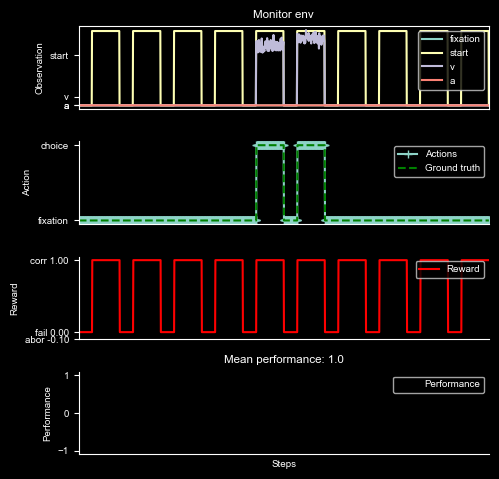

In [15]:
data = ngym.utils.plot_env(
    eval_env, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model
)

In [16]:
train_env.close()
eval_env.close()

We can now train a more complex agent (a recurrent policy) on the same environment.

In [ ]:
model = RecurrentPPO("MlpPolicy", "CartPole-v0")